In [1]:
import gdown

# Download the dataset
url = "https://drive.google.com/drive/folders/1qhhXqA8CjaJs7-E4SjXfhwWn2z4UtABA"
gdown.download_folder(url, quiet=True)

['/home/danis/ML/Data_Analysis_Python/DataCon/Datacon Data/Database_1.xlsx',
 '/home/danis/ML/Data_Analysis_Python/DataCon/Datacon Data/Database_2.xlsx',
 '/home/danis/ML/Data_Analysis_Python/DataCon/Datacon Data/Database_3.xlsx',
 '/home/danis/ML/Data_Analysis_Python/DataCon/Datacon Data/Database_4.xlsx',
 '/home/danis/ML/Data_Analysis_Python/DataCon/Datacon Data/Database_5.xlsx']

In [8]:
import pandas as pd
import numpy as np


# Read the dataset from excel files into pandas databases
db1 = pd.read_excel('Datacon Data/Database_1.xlsx')
db2 = pd.read_excel('Datacon Data/Database_2.xlsx')
db3 = pd.read_excel('Datacon Data/Database_3.xlsx')
db4 = pd.read_excel('Datacon Data/Database_4.xlsx')
db5 = pd.read_excel('Datacon Data/Database_5.xlsx')

db1 = db1.append(db4, ignore_index=True) # first and forth databases had same origin, so we can connect them
db4 = db5

/tmp/ipykernel_27139/2870628235.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  db1 = db1.append(db4, ignore_index=True) # first and forth databases had same origin, so we can connect them


In [9]:
# Function to drop unwanted columns in dataset
def drop_columns(db1, db2, db3, db4):
    db1 = db1.drop(columns=['Elements', 'Electronegativity', 'Ionic radius',
                            'Surface area (m2/g)', 'Number of atoms', 'Molecular weight (g/mol)',
                            'Topological polar surface area (Å²)', 'a (Å)',
                            'b (Å)', 'c (Å)', 'α (°)', 'β (°)', 'γ (°)', 'Density (g/cm3)',
                            ])
    db2 = db2.drop(columns=['coat', 'Cell morphology', 
                            'Cell-organ/tissue source', 'Animal?',
                            'Exposure time (h)', 'Test', 'Test indicator', 'Biochemical metric',
                            'Interference checked (Y/N)', 'Colloidal stability checked (Y/N)',
                            'Positive control (Y/N)', 'Publication year', 'Particle ID', 'Reference DOI'
                            ])
    db3 = db3.drop(columns=['No', 'Year', 'Shape', 'Coat/Functional Group',
                            'Synthesis_Method', 'Size_in_Medium (nm)',
                            'Zeta_in_Medium (mV)', 'No_of_Cells (cells/well)',
                            'Cell_Source', 'Cell_Morphology', 'Time (hr)',
                            'Test', 'Test_Indicator', 'Aspect_Ratio', 'PDI', 'Article_ID', 'DOI'
                            ])
    db4 = db4.drop(columns=['surf_area', 'cell_origin', 'time', 'toxicity'
                            ])
    return db1, db2, db3, db4

In [10]:
# Rename the columns, that had the same meaning, to 
def rename_columns(db1, db2, db3, db4):
    db1.rename(columns={"Material type": "material", # categorical feature
                        "Core size (nm)": "core_size", # numerical
                        "Hydro size (nm)": "hydro_size", # num
                        'Surface charge (mV)': 'surf_charge', # later it will be splitted to binary and numerical
                        'Cell type': 'is_cancer_cell', # cat
                        'Exposure dose (ug/mL)': 'dose', # num
                        'Viability (%)': 'viability', # target, num
                        },
               inplace=True)
   
    db2.rename(columns={"Nanoparticle": "material", # cat
                        "Type: Organic (O)/inorganic (I)": "material_type", # cat
                        "Diameter (nm)": "hydro_size", # num
                        'Zeta potential (mV)': 'surf_charge', # binary and num
                        'Cell line (L)/primary cells (P)': 'cell_line', # bin
                        'Human(H)/Animal(A) cells': 'is_human_cell', # bin
                        'Cell-organ/tissue source': 'cell_origin', # cat
                        'Cells': 'cell_type', # cat
                        'Concentration μM': 'dose', # num
                        'Cell age: embryonic (E), Adult (A)' : 'cell_age', # num
                        '% Cell viability': 'viability' # target, num
                        },
               inplace=True)
    
    db3.rename(columns={"Material": "material", # cat
                        "Type": "material_type", # cat
                        "Diameter (nm)": "core_size", # num
                        "Size_in_Water (nm)": "hydro_size", # num
                        'Zeta_in_Water (mV)': 'surf_charge', # bin and num
                        'Surface_Charge': 'surf_charge_cat', 
                        'Cell Line_Primary Cell': 'cell_line', # bin
                        'Human_Animal': 'is_human_cell', # bin
                        'Cell_Tissue': 'cell_origin', # cat
                        'Cell_Type': 'cell_type', # cat
                        'Concentration (ug/ml)': 'dose', # num
                        'Cell_Age' : 'cell_age', # num
                        'Cell_Viability (%)': 'viability' # target, num
                        },
               inplace=True)

    db4.rename(columns={"material": "material", # cat
                        "core_size": "core_size", # num
                        "hydro_size": "hydro_size", # num
                        'surf_charge': 'surf_charge', # bin and num
                        'cell_line': 'cell_type', # bin
                        'cell_species': 'is_human_cell', # bin
                        'cell_origin': 'cell_origin', # cat
                        'cell_type': 'is_cancer_cell', # cat
                        'cell_line' : 'cell_type', # cat
                        'dose': 'dose', # num
                        'viability': 'viability' # target, num
                        },
               inplace=True)
    return db1, db2, db3, db4

In [11]:
# Function to fill gaps in data and drop if data can not be filled 
def fill_na(db1, db2, db3, db4):
    def zeta_fill(x):
        return 0 if pd.isnull(x) else x

    def sign_potential(x):
        if x < 0:
            return -1
        elif x > 0:
            return 1
        else:
            return 0
    
    def core_fill(core, hydro):
        if not pd.isnull(core):
            return core
        if pd.isnull(core) and not pd.isnull(hydro):
            return hydro/coef_size_to_hydro

    def hydro_fill(core, hydro):
        if not pd.isnull(hydro):
            return hydro
        if pd.isnull(hydro) and not pd.isnull(core):
            return core*coef_size_to_hydro

    def concentration_correction(x):
        if x < 10e-3:
            x *= 10e6
            return x
        else:
            return x

    # Find the average of hydro_size and core_size
    hydro_mean_db1 = np.mean(db1['hydro_size'])
    hydro_count_db1 = db1['hydro_size'].count()
    hydro_mean_db2 = np.mean(db2['hydro_size'])
    hydro_count_db2 = db2['hydro_size'].count()
    hydro_mean_db3 = np.mean(db3['hydro_size'])
    hydro_count_db3 = db3['hydro_size'].count()
    hydro_mean_db4 = np.mean(db4['hydro_size'])
    hydro_count_db4 = db4['hydro_size'].count()

    hydro_size_mean = (hydro_mean_db1*hydro_count_db1+hydro_mean_db2*hydro_count_db2+
    hydro_mean_db3*hydro_count_db3+hydro_mean_db4*hydro_count_db4) / \
    (hydro_count_db1+hydro_count_db2+hydro_count_db3+hydro_count_db4)

    core_mean_db1 = np.mean(db1['core_size'])
    core_count_db1 = db1['core_size'].count()
    core_mean_db3 = np.mean(db3['core_size'])
    core_count_db3 = db3['core_size'].count()
    core_mean_db4 = np.mean(db4['core_size'])
    core_count_db4 = db4['core_size'].count()

    core_size_mean = (core_mean_db1*core_count_db1+
    core_mean_db3*core_count_db3+core_mean_db4*core_count_db4) / \
    (core_count_db1+core_count_db3+core_count_db4)

    coef_size_to_hydro = hydro_size_mean / core_size_mean



    # DB 1
    db1['material_type'] = 'I' # Only inorganic materials in first database
    db1['is_human_cell'] = 1
    db1['surf_charge'] = 0
    db1['surf_charge_cat'] = 0
    db1['cell_age'] = '0'
    db1['cell_origin'] = '0'
    db1['cell_type'] = '0'
    db1['cell_line'] = '0'
    db1.drop(db1[db1['dose'] < 10e-9].index, axis=0, inplace=True) # untrue concentration
    db1 = db1.dropna()

    # DB 2
    db2['surf_charge'] = db2.apply(lambda x: zeta_fill(x['surf_charge']),axis=1)
    db2['surf_charge_cat'] = db2.apply(lambda x: sign_potential(x['surf_charge']),axis=1)
    db2['is_human_cell'] = db2.apply(lambda x: np.where(x['is_human_cell']=='Human', 1, 0),axis=1)
    db2['cell_origin'] = '0'
    db2['core_size'] = db2['hydro_size']/coef_size_to_hydro
    db2['is_cancer_cell'] = -1
    db2.drop(db2[db2['dose'] < 10e-9].index, axis=0, inplace=True)
    db2['dose'] = db2['dose'].apply(lambda x: concentration_correction(x))  # Let's suggest, that molar mass = 1000, conc * 1000 / 1000
    db2.drop(db2[db2['dose'] > 5000].index, axis=0, inplace=True)
    db2 = db2.dropna()

    # DB 3
    db3['surf_charge'] = db3.apply(lambda x: zeta_fill(x['surf_charge']),axis=1)
    db3['surf_charge_cat'] = db3.apply(lambda x: np.where(x['surf_charge_cat']=='Positive', 1, -1), axis=1)
    db3['cell_age'] = db3.apply(lambda x: np.where(x['cell_age']=='Adult', 'A', 'E'), axis=1)
    db3['is_human_cell'] = db3.apply(lambda x: np.where(x['is_human_cell']=='H', 1, 0),axis=1)
    db3['is_cancer_cell'] = -1
    db3['core_size'] = db3.apply(lambda x: core_fill(x['core_size'], x['hydro_size']), axis=1)
    db3['hydro_size'] = db3.apply(lambda x: hydro_fill(x['core_size'], x['hydro_size']), axis=1)
    db3.drop(db3[db3['dose'] < 10e-9].index, axis=0, inplace=True)
    db3 = db3.fillna(value={'core_size':core_size_mean, 'hydro_size':hydro_size_mean,
                            'dose': np.mean(db3['dose'])})
    

    # DB 4
    db4['material_type'] = 'I' # Только неорганические соединения в первой базе данных
    db4['surf_charge'] = db4.apply(lambda x: zeta_fill(x['surf_charge']),axis=1)
    db4['surf_charge_cat'] = db4.apply(lambda x: sign_potential(x['surf_charge']),axis=1)
    db4['is_cancer_cell'] = db4.apply(lambda x: np.where(x['is_cancer_cell']=='Cancer', 1, 0),axis=1)
    db4['is_human_cell'] = db4.apply(lambda x: np.where(x['is_human_cell']=='Human', 1, 0),axis=1)
    db4['cell_age'] = '0'
    db4['cell_origin'] = '0'
    db4['cell_line'] = '0'
    db4.drop(db4[db4['dose'] < 10e-9].index, axis=0, inplace=True)
    db4 = db4.dropna()

    return db1, db2, db3, db4

In [12]:
# Function to merge all databases in one dataset
def merge(db1, db2, db3, db4):
    db1 = db1.append([db2, db3, db4])
    db1 = db1.reset_index().drop('index', axis=1)
    db1 = db1.replace({'15O':150})

    # Feature engineering
    db1['hydro/dose'] = db1['hydro_size']/db1['dose']
    # db1['log_dose'] = np.log10(db1['dose'])
    
    # Correct data types for each feature
    db1 = db1.astype({'material': 'str',
                'core_size': 'float',
                'hydro_size': 'float',
                'surf_charge': 'float',
                'is_cancer_cell': 'int',
                'dose': 'float',
                'viability': 'float',
                'material_type': 'str',
                'is_human_cell': 'str',
                'surf_charge_cat': 'int',
                'cell_age': 'str',
                'cell_origin': 'str',
                'cell_type': 'str',
                'cell_line': 'str',
                'hydro/dose': 'float'})

    return db1

In [13]:
# Function to correct typos in dataset
def corrections(df):    
    df['material'].replace(
                {'Copper Oxide': 'CuO',
                'Zinc oxide': 'ZnO',
                'Iron oxide': 'Fe3O4',
                'IronOxide': 'Fe3O4',
                'IronOide': 'Fe3O4',
                'Ay': 'Au',
                'Ce O2': 'CeO2',
                'Fe3o4': 'Fe3O4',
                "don't remember": 'ZnO',
                'Dendrmer': 'Dendrimer'},
                inplace=True)
    df['material_type'].replace({'0': 'O'}, inplace=True)
    df = df[(df.viability < 200) & (df.viability >=0)]
    df = df[(df.dose <= 5000) & (df.dose >0)]
    return df

In [14]:
# Function to set up a dataset from all the databases that includes all the functions before
def make_great_dataset(db1, db2, db3, db4):
    db1, db2, db3, db4 = drop_columns(db1, db2, db3, db4)
    db1, db2, db3, db4 = rename_columns(db1, db2, db3, db4)
    db1, db2, db3, db4 = fill_na(db1, db2, db3, db4)
    db = merge(db1, db2, db3, db4)
    db = corrections(db)
    db = db.reset_index().drop('index', axis=1)
    return db

In [15]:
db = make_great_dataset(db1, db2, db3, db4)

/tmp/ipykernel_27139/1836539919.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  db1 = db1.append([db2, db3, db4])


In [16]:
db

,material,core_size,hydro_size,surf_charge,is_cancer_cell,dose,viability,material_type,is_human_cell,surf_charge_cat,cell_age,cell_origin,cell_type,cell_line,hydro/dose
0,CuO,12.8,313.8,0.0,1,200.0,9.1000,I,1,0,0,0,0,0,1.5690
1,ZnO,22.6,114.7,0.0,0,200.0,9.5000,I,1,0,0,0,0,0,0.5735
2,ZnO,22.6,114.7,0.0,0,100.0,10.2000,I,1,0,0,0,0,0,1.1470
3,ZnO,22.6,69.4,0.0,1,100.0,11.0000,I,1,0,0,0,0,0,0.6940
4,Mn2O3,51.5,291.7,0.0,1,200.0,11.3000,I,1,0,0,0,0,0,1.4585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8066,ZnO,35.6,236.0,-41.6,1,1.0,127.4363,I,1,-1,0,0,Caco_2,0,236.0000
8067,ZnO,35.6,236.0,-41.6,1,10.0,116.3751,I,1,-1,0,0,Caco_2,0,23.6000
8068,ZnO,35.6,236.0,-41.6,1,100.0,40.8796,I,1,-1,0,0,Caco_2,0,2.3600
8069,ZnO,35.6,236.0,-41.6,1,0.1,86.8566,I,1,-1,0,0,Caco_2,0,2360.0000


In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

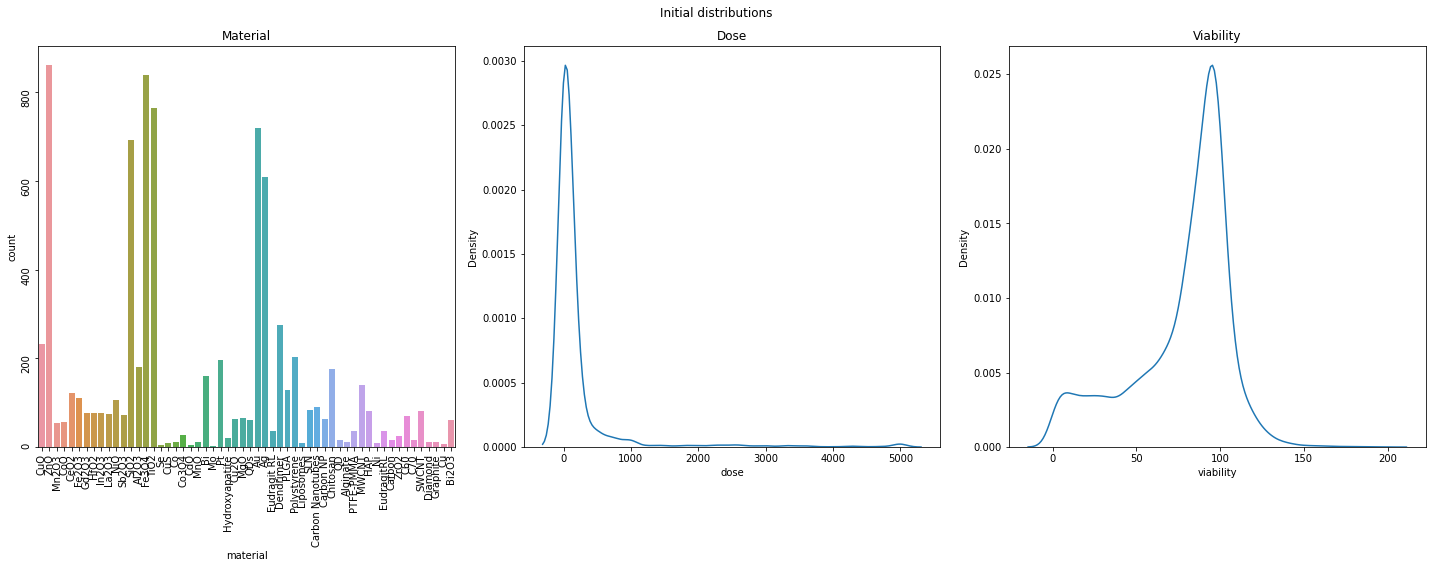

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(20, 8), sharey=False)
fig.suptitle('Initial distributions')


sns.countplot(ax=axes[0], x=db.material)
sns.set_style("whitegrid")
axes[0].set_title('Material')
axes[0].tick_params(axis='both', which='major', labelsize=10, rotation=90)

sns.kdeplot(ax=axes[1], x=db.dose, palette='autumn')
axes[1].set_title('Dose')

sns.kdeplot(ax=axes[2], x=db.viability)
axes[2].set_title('Viability')

fig.tight_layout()

> Целевая переменная имеет вполне приемлемое, хотя и несимметричное распределение. Распределения большей части вещественных признаков имеют распределение, похожее на распределение Парето с большим количеством степеней свободы. В таких ситуациях часто логарифмируют переменные - это позволяет сделать их распределение более похожим на нормальное, однако делает модель сильно менее интерпретируемой и ведет к потере части данных

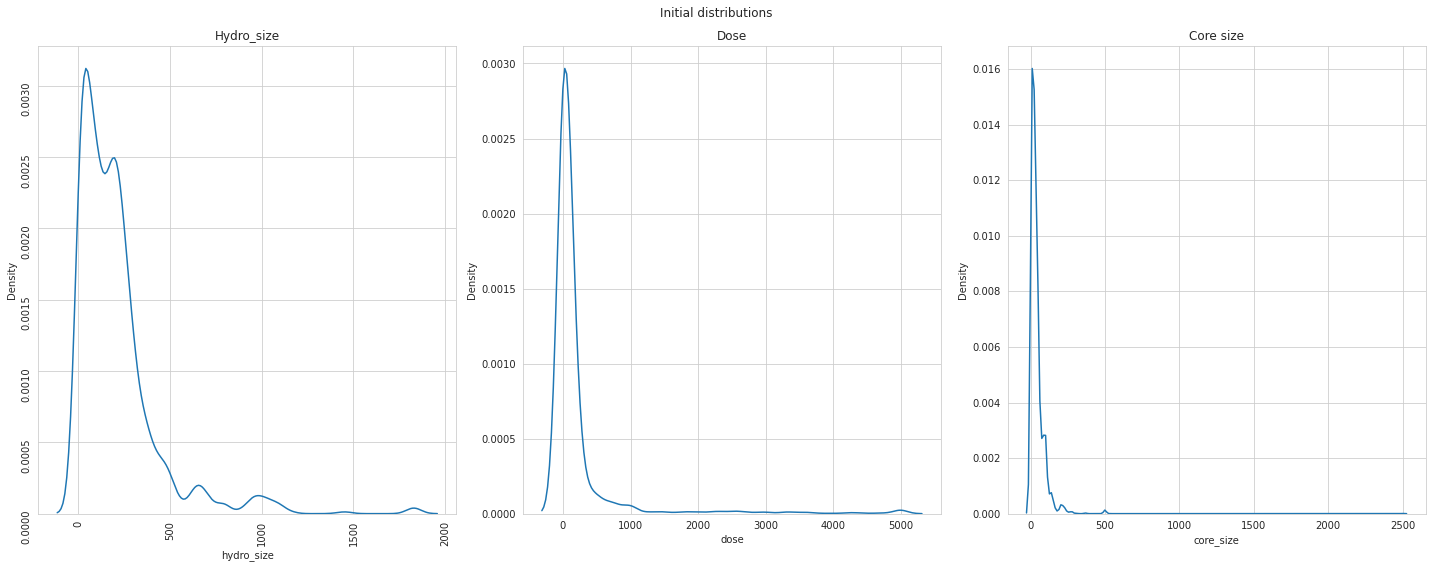

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(20, 8), sharey=False)
fig.suptitle('Initial distributions')

sns.kdeplot(ax=axes[0], x=db.hydro_size)
axes[0].set_title('Hydro_size')
axes[0].tick_params(axis='both', which='major', labelsize=10, rotation=90)

sns.kdeplot(ax=axes[1], x=db.dose)
axes[1].set_title('Dose')

sns.kdeplot(ax=axes[2], x=db.core_size)
axes[2].set_title('Core size')

fig.tight_layout()

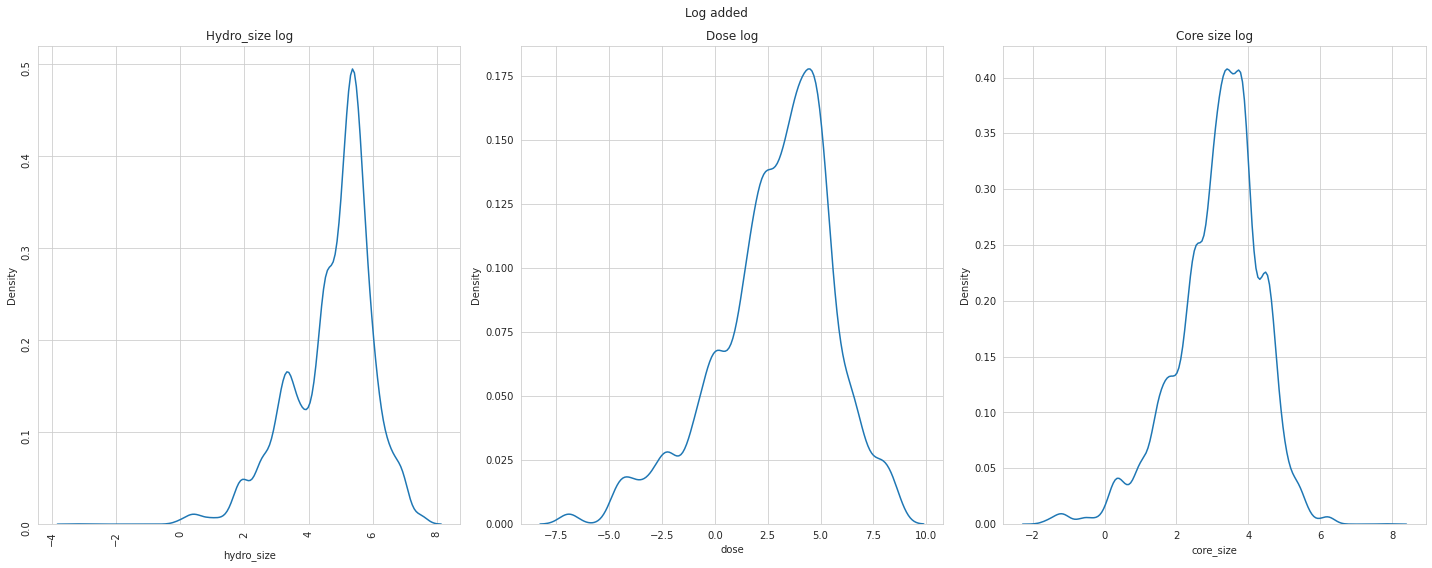

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(20, 8), sharey=False)
fig.suptitle('Log added')

sns.kdeplot(ax=axes[0], x=np.log(db[db.hydro_size > 0].hydro_size))
axes[0].set_title('Hydro_size log')
axes[0].tick_params(axis='both', which='major', labelsize=10, rotation=90)

sns.kdeplot(ax=axes[1], x=np.log(db.dose))
axes[1].set_title('Dose log')

sns.kdeplot(ax=axes[2], x=np.log(db[db.core_size > 0].core_size))
axes[2].set_title('Core size log')

fig.tight_layout()

> Казалось бы, логарифмы могут помочь, однако в виду времязатратной предобработки данных мы решили не строить линейные модели, а сразу обучить бустинг. Логарифм нам в таком случае погоду не сделает, так что применять этот шаг не будем

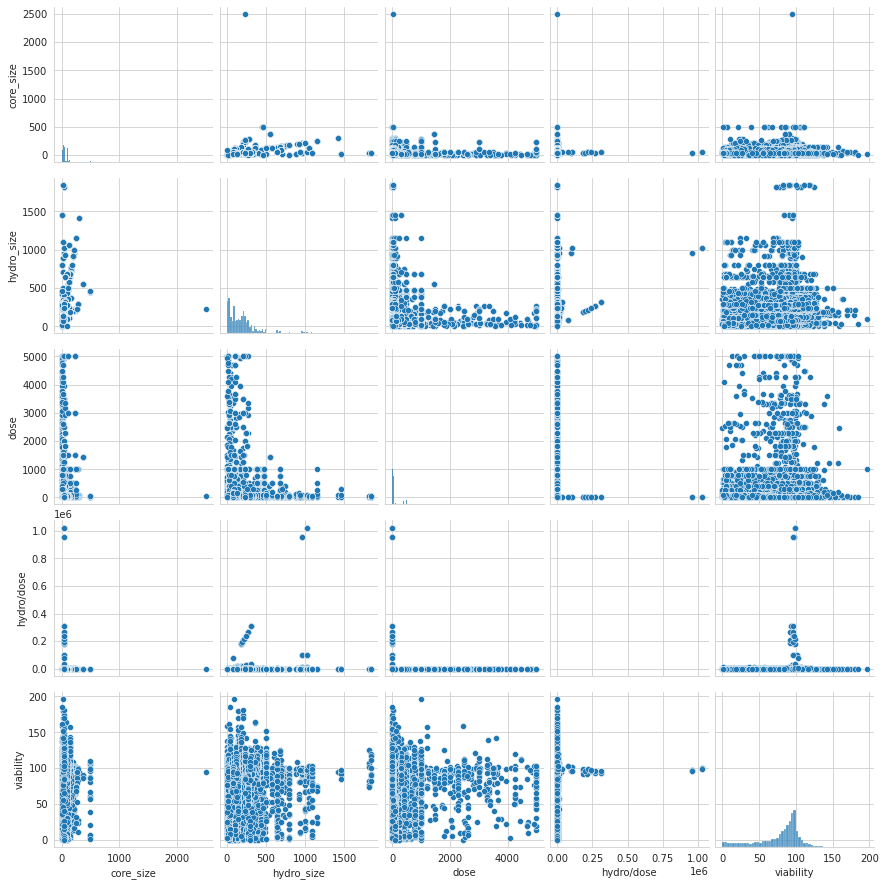

In [17]:
dvis = db[['material', 'core_size', 'hydro_size',
       'dose', 'hydro/dose', 'viability']]
sns.pairplot(dvis);

/tmp/ipykernel_6954/174549855.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


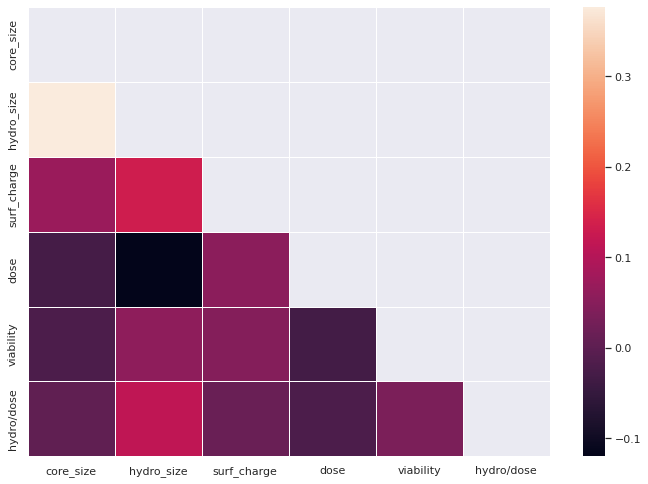

In [18]:
real_feature_mask = (db.dtypes == 'float64').to_numpy()

sns.set(rc={'figure.figsize':(11.7,8.27)})
corr = db[db.columns[real_feature_mask]].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask, linewidths=.5);

>Видим, что отсутсвтвуют видимые корреляции между признаками в датасете. Посмотрим поближе на распределение таргета и некоторых признаков

In [19]:
# Install catboost (gradient boosting framework) and Optuna (hyperparameter optimization framework)
!pip install catboost optuna

In [21]:
from catboost import CatBoostRegressor, cv, Pool

### We have added random noise feature to cut features, that don't add any value. CatboostRegressor was trained by default options and feature importance was extracted from the model.

In [22]:
pd.DataFrame({'imp': {0: 15.873947881243282,
  1: 5.877517509861297,
  2: 5.2814500629667895,
  3: 4.955479114691716,
  4: 3.6804405621794665,
  5: 10.974482273581708,
  6: 4.9077947792131855,
  7: 2.639719968468222,
  8: 6.629298087580424,
  9: 4.116713779680653,
  10: 7.625639511894474,
  11: 9.913760290163601,
  12: 5.33474138703608,
  13: 4.403562998788295,
  14: 7.78545179265031},
 'col': {0: 'material',
  1: 'core_size',
  2: 'hydro_size',
  3: 'surf_charge',
  4: 'is_cancer_cell',
  5: 'dose',
  6: 'material_type',
  7: 'is_human_cell',
  8: 'surf_charge_cat',
  9: 'cell_age',
  10: 'cell_origin',
  11: 'cell_type',
  12: 'cell_line',
  13: 'random',
  14: 'hydro/dose'}}).sort_values(by='imp', ascending=False)

,imp,col
0,15.873948,material
5,10.974482,dose
11,9.913760,cell_type
14,7.785452,hydro/dose
10,7.625640,cell_origin
8,6.629298,surf_charge_cat
1,5.877518,core_size
12,5.334741,cell_line
2,5.281450,hydro_size
3,4.955479,surf_charge


### So cell_age, is_cancer_cell and is_human_cell have lower feature importance than random noise. We can delete these features.

In [23]:
data = db
data = data.drop(columns=['is_human_cell', 'is_cancer_cell', 'cell_age'])

In [24]:
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.model_selection import train_test_split

RANDOM_STATE = 42
TEST_SIZE = 0.2
TARGET_NAME = 'viability'
np.random.seed(RANDOM_STATE)

cat_features = ['material', 'material_type', 
                'surf_charge_cat', 'cell_type', 
                'cell_origin',  'cell_line']

X = data.drop(columns=['viability'], axis=1)
y = data['viability']

In [25]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=TEST_SIZE, 
                                                    stratify=X['material'],
                                                    random_state=RANDOM_STATE)

### We decided to do some hyperparameter optimization for our CatboostRegressor model. We used the Optuna framework.

In [30]:
def objective(trial):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, 
                                                        stratify=X['material'],
                                                        random_state=RANDOM_STATE)

    # Limit of parameter values for optimization
    param = {
        "loss_function": trial.suggest_categorical("loss_function", ["RMSE", "MAE"]),
        "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-2, 1e0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 10),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 2, 20),
        "one_hot_max_size": trial.suggest_int("one_hot_max_size", 2, 20),  
    }
    # Conditional Hyper-Parameters
    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    reg = CatBoostRegressor(**param, cat_features=cat_features)
    reg.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0, early_stopping_rounds=100)
    y_pred = reg.predict(X_test)
    score = MAE(y_test, y_pred)
    return score

In [ ]:
import optuna
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=250, timeout=600)
trial = study.best_trial

### Here you can see the the best parameters that Optuna calculated. We will use them in our final model.

In [ ]:
print("Best Score: {}".format(trial.value))
print("Best Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Best Score: 12.500086444545081
Best Params: 
    loss_function: RMSE
    l2_leaf_reg: 0.10316964527875554
    colsample_bylevel: 0.09541076028546017
    depth: 10
    boosting_type: Plain
    bootstrap_type: MVS
    min_data_in_leaf: 18
    one_hot_max_size: 2


In [26]:
# Parameters obtained by optimizing hyperparameters with Optuna
params = {'loss_function': 'RMSE',
          'l2_leaf_reg': 0.10316964527875554,
          'colsample_bylevel': 0.09541076028546017,
          'depth': 10,
          'boosting_type': 'Plain',
          'bootstrap_type': 'MVS',
          'min_data_in_leaf': 18,
          'one_hot_max_size': 2}

### To ensure that the model dont overfit, we used crossvalidation using sklearn's KFold split.

In [20]:
import gc
from sklearn.model_selection import KFold
NFOLDS = 5
folds = KFold(n_splits=NFOLDS)
columns = X_train.columns
splits = folds.split(X_train, y_train)
y_oof = np.zeros(X_train.shape[0])
score = 0
  
for fold_n, (train_index, valid_index) in enumerate(splits):
    X_tr, X_val = X_train[columns].iloc[train_index], X_train[columns].iloc[valid_index]
    y_tr, y_val = y_train.iloc[train_index], y_train.iloc[valid_index]    

    model = CatBoostRegressor(**params, learning_rate=0.003, iterations=50000, task_type='CPU')
    
    model.fit(X_tr, y_tr, eval_set=(X_val, y_val), cat_features=cat_features, early_stopping_rounds=500, verbose=0)
    y_pred_valid = model.predict(X_val)
    y_oof[valid_index] = y_pred_valid
    print(f"Fold {fold_n + 1} | MAE: {MAE(y_val, y_pred_valid)}")   
    score += MAE(y_val, y_pred_valid) / NFOLDS
    del X_tr, X_val, y_tr, y_val
    gc.collect() 
    
print(f"\nMean MAE = {score}")
print(f"Out of folds MAE = {MAE(y_train, y_oof)}")

Fold 1 | MAE: 13.113173720472396
Fold 2 | MAE: 13.388517347260217
Fold 3 | MAE: 13.220920966244766
Fold 4 | MAE: 12.736958657051733
Fold 5 | MAE: 13.543170715475108

Mean MAE = 13.200548281300843
Out of folds MAE = 13.200534747446937


In [27]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE


model = CatBoostRegressor(**params, learning_rate=0.003, iterations=50000, task_type='CPU', verbose=0)
model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=cat_features, early_stopping_rounds=500)

preds = model.predict(X_valid)

print(f'RMSE:{MSE(y_valid, preds, squared=False)}')
print(f'r2_score:{r2_score(y_valid, preds)}')
print(f'MAE:{MAE(y_valid, preds)}')

RMSE:18.398557984238725
r2_score:0.6172805974409594
MAE:12.681222958769732


final diagnostics of the model: \
RMSE: 18.39 \
MAE:12.68 \
r2_score: 0.62

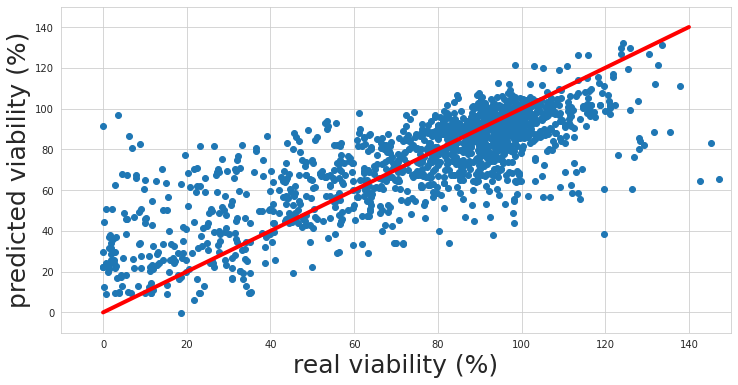

In [28]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D  

plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
x_line = y_line = [0,140]

plt.xlim(-10, 150)
plt.ylim(-10, 150)
plt.scatter(y_valid, preds)
plt.xlabel('real viability (%)', fontsize=25)
plt.ylabel('predicted viability (%)', fontsize=25)
plt.plot(x_line,y_line, c='red', linewidth=4)

plt.show()

In [25]:
!pip install shap statsmodels numba

In [21]:
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
import shap

from catboost import CatBoostRegressor, Pool

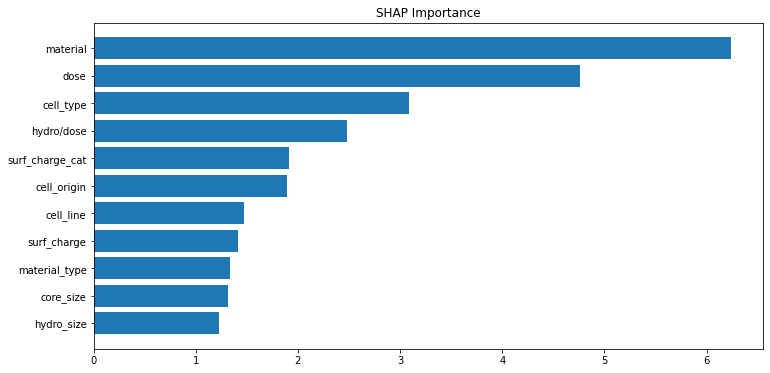

In [22]:
explainer = shap.Explainer(model)
shap_values = explainer(X_valid)
shap_importance = shap_values.abs.mean(0).values
sorted_idx = shap_importance.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), shap_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_valid.columns)[sorted_idx])
plt.title('SHAP Importance');

In [23]:
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_valid)gi

# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], X_valid.iloc[0,:])


 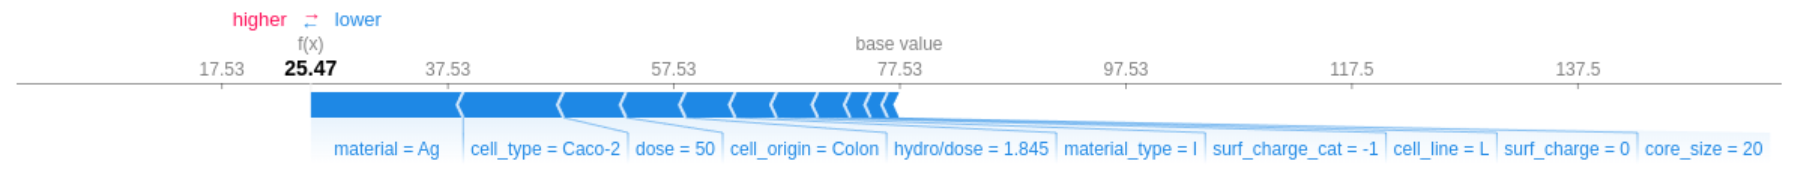

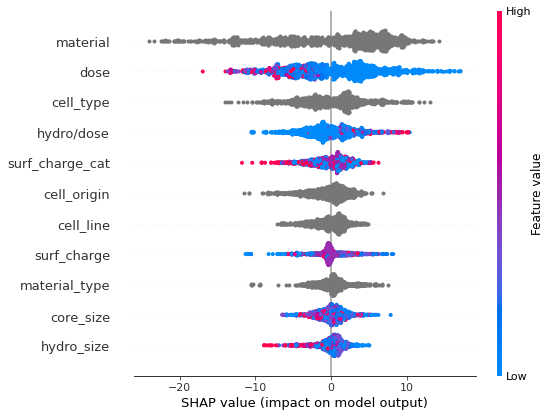

In [24]:
shap.summary_plot(shap_values, X_valid)